In [1]:
from scipy import sparse
import numpy as np
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F

from matplotlib import pyplot as plt
import os
import time
import copy
import torch.optim as optim

from utils import *
from models import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# test_size = 0.9
# lr = 0.0001
# emb_dim = 64
# dropout_rate = 0.0
# weight_decay = 0.00001
# epochs = 100
# batch_size = 128
# milestones = [10, 40, 60, 80]
# model_origin = DHCF_2
# model_ours = DHCF_2

# category_rate = 1

In [77]:
test_size = 0.9
lr = 0.001
emb_dim = 64
dropout_rate = 0.0
weight_decay = 0.00001
epochs = 100
batch_size = 128
milestones = [10, 40, 60, 80]
model_origin = DHCF_2
model_ours = DHCF_2

category_rate = 1

In [78]:
ml100k_user = sparse.load_npz('./ml100k_useritem_incidence.npz')
ml100k_item = sparse.load_npz('./ml100k_item_aka_movie_incidence.npz')

# 유저, 아이템 인덱스가 1부터 시작하는 데이터로 만들어서 모양이 943, 1682에서 1씩 큼. 인덱스를 0으로 시작하도록 만들어 주는 코드가 아래 한 줄
ml100k_user = sparse.csr_matrix((ml100k_user.data, np.array([_-1 for _ in ml100k_user.indices]), ml100k_user.indptr[1:]), shape = (ml100k_user.shape[0] - 1, ml100k_user.shape[1] - 1) )

# 각 edge가 1~5로 매칭되어 있는 부분을 전부 1로 변환
ml100k_user.data = np.ones_like(ml100k_user.data)

# 학습용, 평가용 나누기
H_u_train, H_u_test = split_per_one_user(ml100k_user, test_size_ = test_size, use_ranking = False)

In [79]:
# torch.sparse_coo_tensor로 변경
H_u_train_ = sps2torchsparse(H_u_train)
category_data = sps2torchsparse(ml100k_item)
category_data = torch.sparse_coo_tensor(torch.stack((category_data._indices()[0], category_data._indices()[1] + ml100k_user.shape[1])), category_data._values())

# High order connectivity 추가
H_u = add_high_order(H_u_train_)
H_i = add_high_order(H_u_train_.t())
H_i2 = torch.concat((H_i, category_data * category_rate), dim = 1)
# G_i, G_u 계산
G_i = Generate_G_from_H(H_i).to_dense().to(device)
G_u = Generate_G_from_H(H_u).to_dense().to(device)
G_i2 = Generate_G_from_H(H_i2).to_dense().to(device)
G_u2 = Generate_G_from_H(H_u).to_dense().to(device)
# model 생성
model_i = model_origin(in_ch = H_i.shape[0], hid_ch = emb_dim, i_emb = emb_dim, dropout_rate = dropout_rate).to(device)
model_u = model_origin(in_ch = H_u.shape[0], hid_ch = emb_dim, i_emb = emb_dim, dropout_rate = dropout_rate).to(device)

model_i2 = model_ours(in_ch = H_i.shape[0], hid_ch = emb_dim, i_emb = emb_dim, dropout_rate = dropout_rate).to(device)
model_u2 = model_ours(in_ch = H_u.shape[0], hid_ch = emb_dim, i_emb = emb_dim, dropout_rate = dropout_rate).to(device)

metric = mymetric()

optimizer_i = optim.Adam(model_i.parameters(), lr = lr, weight_decay=weight_decay)
optimizer_u = optim.Adam(model_u.parameters(), lr = lr, weight_decay=weight_decay)
optimizer_i2 = optim.Adam(model_i2.parameters(), lr = lr, weight_decay=weight_decay)
optimizer_u2 = optim.Adam(model_u2.parameters(), lr = lr, weight_decay=weight_decay)

scheduler_i = optim.lr_scheduler.MultiStepLR(optimizer_i, milestones=milestones, gamma=0.5)
scheduler_u = optim.lr_scheduler.MultiStepLR(optimizer_u, milestones=milestones, gamma=0.5)
scheduler_i2 = optim.lr_scheduler.MultiStepLR(optimizer_i2, milestones=milestones, gamma=0.5)
scheduler_u2 = optim.lr_scheduler.MultiStepLR(optimizer_u2, milestones=milestones, gamma=0.5)

criterion = bpr_loss
criterion2 = bpr_loss

gt = ml100k_user.toarray()

input_i = torch.arange(ml100k_user.shape[1]).to(device)
input_u = torch.arange(ml100k_user.shape[0]).to(device)

In [80]:
# model training
running_losses, val_losses = [], []
running_losses2, val_losses2 = [], []
val_acc = {'ndcg' : [], 'recall' : [], 'precision' : []}
val_acc2 = {'ndcg' : [], 'recall' : [], 'precision' : []}

# G_i_droped = G_i
# G_u_droped = G_u
# G_i_droped2 = G_i2
# G_u_droped2 = G_u2

for epoch in range(epochs):
    start_time = time.time()
    running_loss, val_loss = 0, 0
    running_loss2, val_loss2 = 0, 0

    H_i_droped = first_dropout(H_i, dropout_rate=dropout_rate)
    H_u_droped = first_dropout(H_u, dropout_rate=dropout_rate)
    G_i_droped = Generate_G_from_H(H_i_droped).to_dense().to(device)
    G_u_droped = Generate_G_from_H(H_u_droped).to_dense().to(device)
    H_i_droped2 = first_dropout(H_i2, dropout_rate=dropout_rate)
    H_u_droped2 = first_dropout(H_u, dropout_rate=dropout_rate)
    G_i_droped2 = Generate_G_from_H(H_i_droped2).to_dense().to(device)
    G_u_droped2 = Generate_G_from_H(H_u_droped2).to_dense().to(device)

    # train
    model_i.train()
    model_u.train()
    model_i2.train()
    model_u2.train()
    with torch.set_grad_enabled(True):
        for u,p,n in data_generator(H_u_train, batch_size):
            optimizer_i.zero_grad()
            optimizer_u.zero_grad()
            optimizer_i2.zero_grad()
            optimizer_u2.zero_grad()
            i_output = model_i(input_i, G_i_droped)
            u_output = model_u(input_u, G_u_droped)
            i_output2 = model_i2(input_i, G_i_droped2)
            u_output2 = model_u2(input_u, G_u_droped2)

            users = torch.index_select(u_output, 0, torch.tensor(u).to(device))
            pos_items = torch.index_select(i_output, 0, torch.tensor(p).long().to(device))
            neg_items = torch.index_select(i_output, 0, torch.tensor(n).long().to(device))
            users2 = torch.index_select(u_output2, 0, torch.tensor(u).to(device))
            pos_items2 = torch.index_select(i_output2, 0, torch.tensor(p).long().to(device))
            neg_items2 = torch.index_select(i_output2, 0, torch.tensor(n).long().to(device))
            
            batch_loss, batch_mf_loss, batch_emb_loss = criterion(users, pos_items=pos_items, neg_items=neg_items, decay=weight_decay)
            batch_loss2, batch_mf_loss2, batch_emb_loss2 = criterion2(users2, pos_items=pos_items2, neg_items=neg_items2, decay=weight_decay)

            batch_loss.backward()
            batch_loss2.backward()
            optimizer_i.step()
            optimizer_u.step()
            optimizer_i2.step()
            optimizer_u2.step()

            running_loss += batch_loss.item()
            running_loss2 += batch_loss2.item()

    running_losses.append(running_loss)
    running_losses2.append(running_loss2)
    scheduler_i.step()
    scheduler_u.step()
    scheduler_i2.step()
    scheduler_u2.step()

    # eval
    model_i.eval()
    model_u.eval()
    model_i2.eval()
    model_u2.eval()
    with torch.set_grad_enabled(False):
        for u,p,n in data_generator(H_u_test, batch_size):
            i_output = model_i(input_i, G_i)
            u_output = model_u(input_u, G_u)
            i_output2 = model_i2(input_i, G_i2)
            u_output2 = model_u2(input_u, G_u2)

            users = torch.index_select(u_output, 0, torch.tensor(u).to(device))
            pos_items = torch.index_select(i_output, 0, torch.tensor(p).long().to(device))
            neg_items = torch.index_select(i_output, 0, torch.tensor(n).long().to(device))
            users2 = torch.index_select(u_output2, 0, torch.tensor(u).to(device))
            pos_items2 = torch.index_select(i_output2, 0, torch.tensor(p).long().to(device))
            neg_items2 = torch.index_select(i_output2, 0, torch.tensor(n).long().to(device))
            
            batch_loss, batch_mf_loss, batch_emb_loss = criterion(users, pos_items=pos_items, neg_items=neg_items, decay=weight_decay)
            batch_loss2, batch_mf_loss2, batch_emb_loss2 = criterion2(users2, pos_items=pos_items2, neg_items=neg_items2, decay=weight_decay)

            val_loss += batch_loss.item()
            val_loss2 += batch_loss2.item()
        rec = np.array((u_output @ i_output.T).detach().to('cpu'))
        rec2 = np.array((u_output2 @ i_output2.T).detach().to('cpu'))

        for i in range(H_u_train.shape[0]):
            train_indices = H_u_train[i].indices
            rec[i][train_indices] = -1024
            rec2[i][train_indices] = -1024

        val_ndcg = metric._ndcg(rec = rec, gt = ml100k_user, k=20)
        val_recall = metric._recall(rec = rec, gt = ml100k_user, k=20)
        val_ndcg2 = metric._ndcg(rec = rec2, gt = ml100k_user, k=20)
        val_recall2 = metric._recall(rec = rec2, gt = ml100k_user, k=20)
        val_precision = metric._precision(rec = rec, gt = ml100k_user, k=20)
        val_precision2 = metric._precision(rec = rec2, gt = ml100k_user, k=20)
    val_losses.append(val_loss)
    val_acc['ndcg'].append(val_ndcg)
    val_acc['recall'].append(val_recall)
    val_acc['precision'].append(val_precision)
    val_losses2.append(val_loss2)
    val_acc2['ndcg'].append(val_ndcg2)
    val_acc2['recall'].append(val_recall2)
    val_acc2['precision'].append(val_precision2)


    if (epoch + 1) % 10 == 0:
        print('Epoch : {}, running_loss : {:.6f}, val_loss : {:.6f}, time : {:.2f}'.format(epoch + 1, running_loss, val_loss, time.time() - start_time))
        print('NDCG : {:.6f}, Recall : {:.6f}, Precision : {:.6f}'.format(np.mean(val_ndcg), np.mean(val_recall), np.mean(val_precision)))
        print('Epoch : {}, running_loss2 : {:.6f}, val_loss2 : {:.6f}, time : {:.2f}'.format(epoch + 1, running_loss2, val_loss2, time.time() - start_time))
        print('NDCG2 : {:.6f}, Recall2 : {:.6f}, Precision2 : {:.6f}'.format(np.mean(val_ndcg2), np.mean(val_recall2), np.mean(val_precision2)))
        print('-' * 60)

Epoch : 10, running_loss : 3.092721, val_loss : 3.378389, time : 10.69
NDCG : 0.365466, Recall : 0.103293, Precision : 0.343902
Epoch : 10, running_loss2 : 3.014210, val_loss2 : 3.324444, time : 10.69
NDCG2 : 0.355202, Recall2 : 0.110429, Precision2 : 0.345016
------------------------------------------------------------
Epoch : 20, running_loss : 2.726993, val_loss : 3.226750, time : 13.85
NDCG : 0.388307, Recall : 0.109212, Precision : 0.369406
Epoch : 20, running_loss2 : 2.713292, val_loss2 : 3.238878, time : 13.85
NDCG2 : 0.373067, Recall2 : 0.111363, Precision2 : 0.365589
------------------------------------------------------------
Epoch : 30, running_loss : 2.593092, val_loss : 3.078541, time : 10.14
NDCG : 0.381894, Recall : 0.113454, Precision : 0.356734
Epoch : 30, running_loss2 : 2.570329, val_loss2 : 3.153461, time : 10.14
NDCG2 : 0.384053, Recall2 : 0.113991, Precision2 : 0.365801
------------------------------------------------------------
Epoch : 40, running_loss : 2.65215

train losses


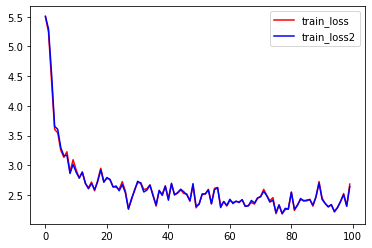

val losses


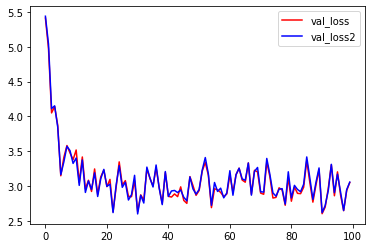

val ndcg


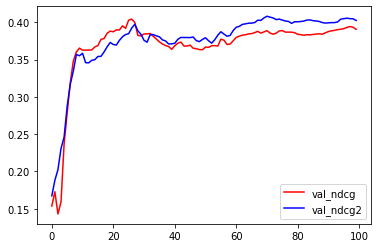

val recall


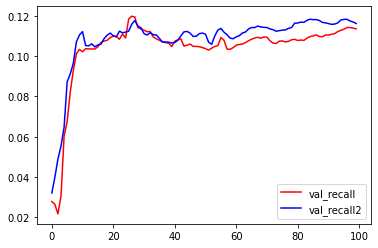

val precision


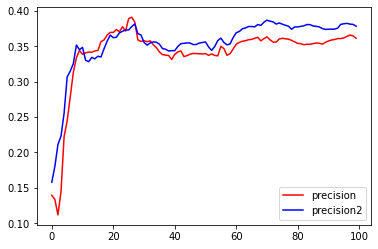

val max ndcg, recall
0.4043780038540821
0.4082637528586579
0.11971533410086271
0.11825446514220987
0.3908271474019088
0.3866914103923648
val last ndcg, recall
0.39074683291918605
0.4026066893380832
0.11347972248470213
0.11614365659893777
0.36113467656415693
0.37810180275715805


In [81]:
def ploting_list(one_dim_list, c = 'b', label = 'metric'):
    length = len(one_dim_list)
    plt.plot(range(length), one_dim_list, c = c, label = label)

print('train losses')
ploting_list(running_losses, 'r', 'train_loss')
ploting_list(running_losses2, 'b', 'train_loss2')
plt.legend()
plt.show()

print('val losses')
ploting_list(val_losses, 'r', 'val_loss')
ploting_list(val_losses2, 'b', 'val_loss2')
plt.legend()
plt.show()

print('val ndcg')
ploting_list([np.mean(i) for i in val_acc['ndcg']], 'r', 'val_ndcg')
ploting_list([np.mean(i) for i in val_acc2['ndcg']], 'b', 'val_ndcg2')
plt.legend()
plt.show()

print('val recall')
ploting_list([np.mean(i) for i in val_acc['recall']], 'r', 'val_recall')
ploting_list([np.mean(i) for i in val_acc2['recall']], 'b', 'val_recall2')
plt.legend()
plt.show()

print('val precision')
ploting_list([np.mean(i) for i in val_acc['precision']], 'r', 'precision')
ploting_list([np.mean(i) for i in val_acc2['precision']], 'b', 'precision2')
plt.legend()
plt.show()

print('val max ndcg, recall')
print(np.max([np.mean(i) for i in val_acc['ndcg']]))
print(np.max([np.mean(i) for i in val_acc2['ndcg']]))
print(np.max([np.mean(i) for i in val_acc['recall']]))
print(np.max([np.mean(i) for i in val_acc2['recall']]))
print(np.max([np.mean(i) for i in val_acc['precision']]))
print(np.max([np.mean(i) for i in val_acc2['precision']]))
print('val last ndcg, recall')
print([np.mean(i) for i in val_acc['ndcg']][-1])
print([np.mean(i) for i in val_acc2['ndcg']][-1])
print([np.mean(i) for i in val_acc['recall']][-1])
print([np.mean(i) for i in val_acc2['recall']][-1])
print([np.mean(i) for i in val_acc['precision']][-1])
print([np.mean(i) for i in val_acc2['precision']][-1])